<a href="https://colab.research.google.com/github/MustansirVerdawala/MachineLearning/blob/main/KMeansClustering/KMeansClustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

In [ ]:
# Upload dataset
from google.colab import files
uploaded = files.upload()

Saving Online Retail.xlsx to Online Retail.xlsx


In [ ]:
df = pd.read_excel("Online Retail.xlsx")
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [ ]:
df.shape

(541909, 8)

In [ ]:
# Drop unnecessary columns
df = df.drop(columns=['StockCode', 'Description'])

# Engineer this feature
df['TotalPrice'] = df['Quantity'] * df['UnitPrice']

In [ ]:
# Check null entries
df.isnull().sum()

,0
InvoiceNo,0
Quantity,0
InvoiceDate,0
UnitPrice,0
CustomerID,135080
Country,0
TotalPrice,0


In [ ]:
# Drop all rows with missing CustomerID
df = df.dropna(subset=['CustomerID'])

# Drop rows with zero or negative Quantity or UnitPrice
df = df[(df['Quantity'] > 0) & (df['UnitPrice'] > 0)]

# Convert InvoiceDate to datetime format (if not already)
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

In [ ]:
# Eliminate geographical clusters by focusing on the biggest markets - UK in this case
country_counts = df['Country'].value_counts()
print(country_counts)

Country
United Kingdom          354321
Germany                   9040
France                    8341
EIRE                      7236
Spain                     2484
Netherlands               2359
Belgium                   2031
Switzerland               1841
Portugal                  1462
Australia                 1182
Norway                    1071
Italy                      758
Channel Islands            748
Finland                    685
Cyprus                     614
Sweden                     451
Austria                    398
Denmark                    380
Poland                     330
Japan                      321
Israel                     248
Unspecified                244
Singapore                  222
Iceland                    182
USA                        179
Canada                     151
Greece                     145
Malta                      112
United Arab Emirates        68
European Community          60
RSA                         57
Lebanon                     45


In [ ]:
df = df[df['Country'] == 'United Kingdom'].copy()

In [ ]:
# Engineer RFM features - Recency, Frequency, Monetary

NOW = df['InvoiceDate'].max() + pd.Timedelta(days=1)
print("Reference Date (NOW):", NOW)

rfm = df.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (NOW - x.max()).days,  # Recency: days since last purchase
    'InvoiceNo': 'nunique',                         # Frequency: number of unique invoices
    'TotalPrice': 'sum'                             # Monetary: total spent
})

# Rename columns for clarity
rfm.columns = ['Recency', 'Frequency', 'Monetary']
rfm = rfm.reset_index()

rfm.head()

Reference Date (NOW): 2011-12-10 12:49:00


,CustomerID,Recency,Frequency,Monetary
0,12346.0,326,1,77183.60
1,12747.0,2,11,4196.01
2,12748.0,1,209,33719.73
3,12749.0,4,5,4090.88
4,12820.0,3,4,942.34


In [ ]:
rfm.shape

(3920, 4)

In [ ]:
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm[['Recency', 'Frequency', 'Monetary']])

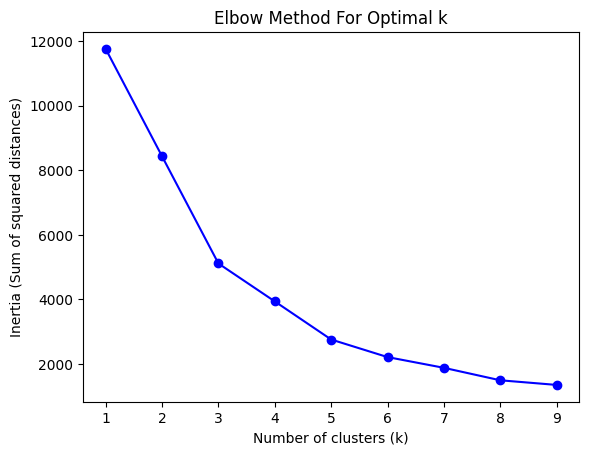

In [ ]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

inertia = []
K = range(1, 10)
for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(rfm_scaled)
    inertia.append(kmeans.inertia_)

plt.plot(K, inertia, 'bo-')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Inertia (Sum of squared distances)')
plt.title('Elbow Method For Optimal k')
plt.show()

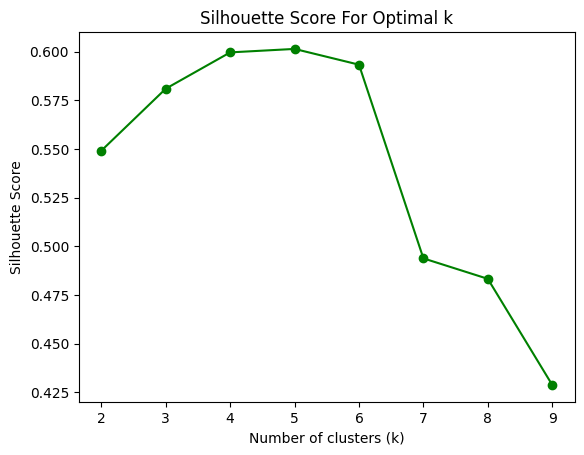

In [ ]:
from sklearn.metrics import silhouette_score

sil_scores = []
for k in range(2, 10):
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(rfm_scaled)
    score = silhouette_score(rfm_scaled, labels)
    sil_scores.append(score)

plt.plot(range(2, 10), sil_scores, 'go-')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score For Optimal k')
plt.show()

In [ ]:
k = 5
kmeans = KMeans(n_clusters=k, random_state=42)
rfm['Cluster'] = kmeans.fit_predict(rfm_scaled)

# Check how many customers fall into each cluster
print(rfm['Cluster'].value_counts())

# Show cluster centroids for fun and analysis
centroids = kmeans.cluster_centers_
print("Cluster centroids (scaled):\n", centroids)

Cluster
1    2646
0     963
3     289
2      19
4       3
Name: count, dtype: int64
Cluster centroids (scaled):
 [[ 1.55528008 -0.37324442 -0.1906614 ]
 [-0.47693028 -0.12711153 -0.09681363]
 [-0.86834746  8.68860476  6.39500157]
 [-0.74947923  1.79049888  0.8158927 ]
 [-0.89302704  4.41126957 27.49259265]]


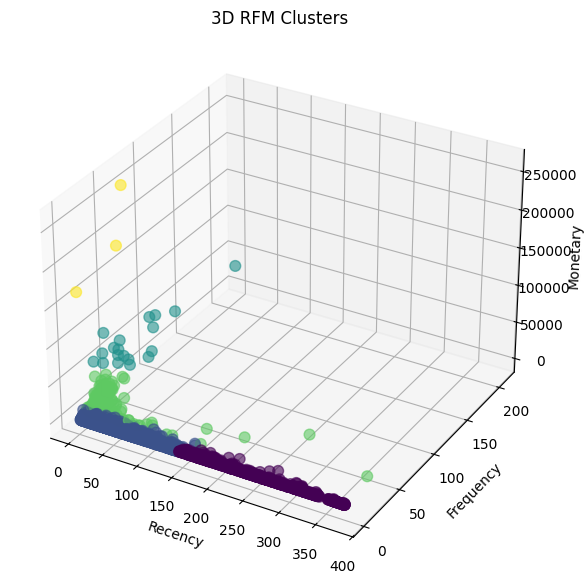

In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

# Assume 'df' is your scaled RFM dataframe and 'clusters' is your cluster label column
ax.scatter(rfm['Recency'], rfm['Frequency'], rfm['Monetary'],
           c=rfm['Cluster'], cmap='viridis', alpha=0.6, s=60)

ax.set_xlabel('Recency')
ax.set_ylabel('Frequency')
ax.set_zlabel('Monetary')
ax.set_title('3D RFM Clusters')

plt.show()

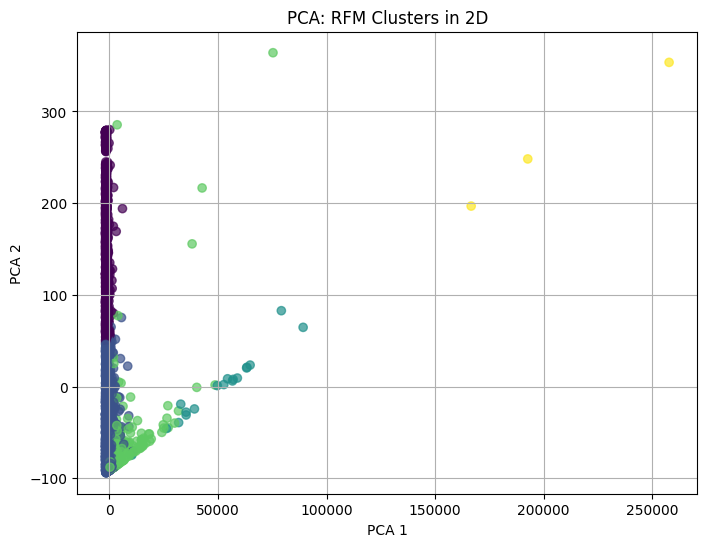

In [ ]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
pca_components = pca.fit_transform(rfm[['Recency', 'Frequency', 'Monetary']])

plt.figure(figsize=(8, 6))
plt.scatter(pca_components[:, 0], pca_components[:, 1], c=rfm['Cluster'], cmap='viridis', alpha=0.7)
plt.title('PCA: RFM Clusters in 2D')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.grid(True)
plt.show()

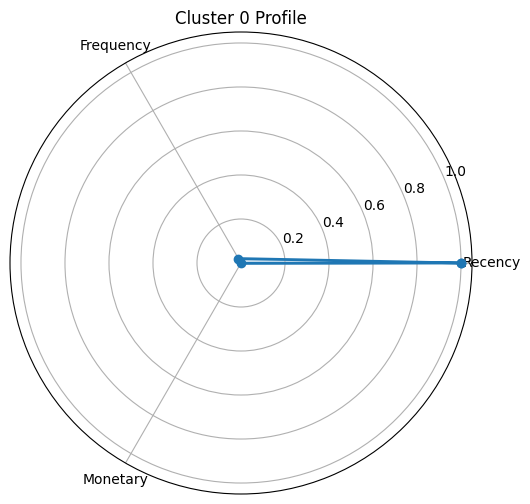

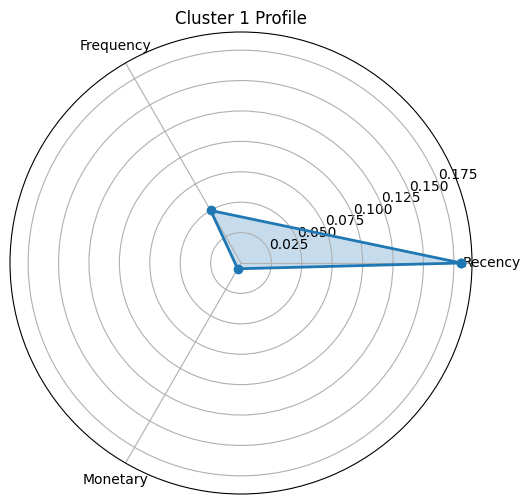

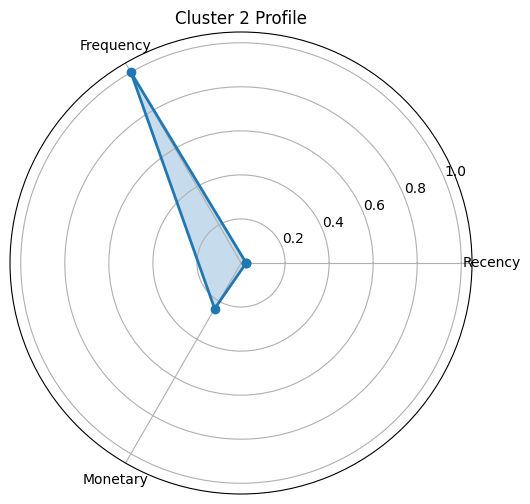

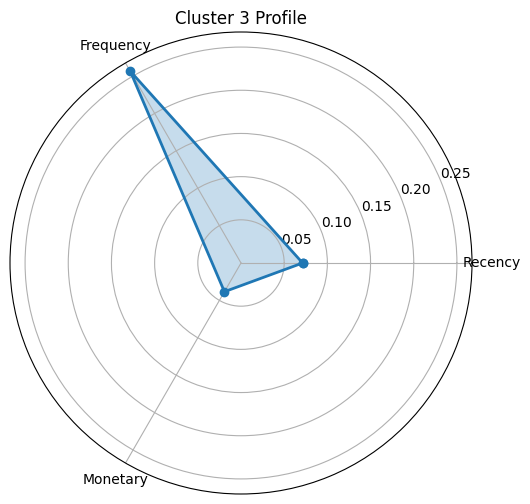

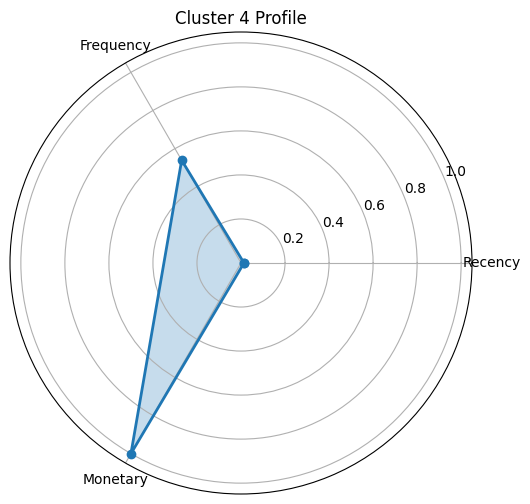

In [ ]:
import numpy as np

def radar_chart(df_grouped, cluster_id):
    labels = ['Recency', 'Frequency', 'Monetary']
    stats = df_grouped.loc[cluster_id].values

    angles = np.linspace(0, 2 * np.pi, len(labels), endpoint=False).tolist()
    stats = np.concatenate((stats, [stats[0]]))
    angles += angles[:1]

    fig, ax = plt.subplots(figsize=(6, 6), subplot_kw=dict(polar=True))
    ax.plot(angles, stats, 'o-', linewidth=2)
    ax.fill(angles, stats, alpha=0.25)
    ax.set_thetagrids(np.degrees(angles[:-1]), labels)
    ax.set_title(f'Cluster {cluster_id} Profile')
    plt.show()

cluster_avg = rfm.groupby('Cluster')[['Recency', 'Frequency', 'Monetary']].mean()

# Normalize the values before plotting
rfm_norm = cluster_avg / cluster_avg.max()
for i in rfm_norm.index:
    radar_chart(rfm_norm, i)

In [ ]:
'''Cluster 0: “High frequency, moderate spenders – likely regular, loyal customers.”

Cluster 1: “Low frequency, low monetary – casual or first-time buyers.”

Cluster 2: “Frequent and high spenders – VIPs. Your moneybags. Treat them like royalty.”

Clusters 3 & 4: Probably Noise or Outliers - even otherwise, very small consumer market to focus on. '''